# **Emoji Classification Project - Computer Vision**

### Team Members : `Daniil NOTKIN`, `Yuhan SU` & `Yassine ERRAJI`

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## *Importations*

In [3]:
from warnings import filterwarnings
filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from PIL import Image
from skimage import io, color
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


## *Functions*

In [4]:
def load_single_image(path):
    """
    This will be the function you use to preprocess your image.

    """
    img = Image.open(path).convert("RGBA")
    img = np.array(img)

    # RGBA -> RGB
    if img.ndim == 3 and img.shape[2] == 4:
        img = color.rgba2rgb(img)
    # grayscale -> RGB
    elif img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)

    # unint8 conversion
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # additional preprocessing
    img = preprocess_input((img * 255.0).astype("float32"))

    return img.astype("float32") / 255.0


# ============================================================
# Improved imageLoader
# - shuffles every epoch
# - resizes images
# - optional data augmentation
# - optional sample weights (to replace class_weight)
# ============================================================


def imageLoader(
    files,
    labels,
    batch_size,
    target_size=(72, 72),
    augment=False,
    class_weight=None,   # NEW: dict like {class_index: weight}
    seed=37              # NEW: for reproducibility if you want it
):
    """
    Python generator yielding:
      - (X, y) if class_weight is None
      - (X, y, sample_weight) if class_weight is provided

    Notes:
    - labels must be a dict: {img_id (string): label_name (string)}
    - label_to_index must already exist in the notebook scope
    """

    rng = np.random.default_rng(seed)

    files = np.array(files)
    L = len(files)

    while True:
        # Shuffle at the beginning of each epoch
        indices = rng.permutation(L)
        files_shuffled = files[indices]

        batch_start = 0
        while batch_start < L:
            batch_files = files_shuffled[batch_start:batch_start + batch_size]

            X_batch = np.empty((len(batch_files), target_size[1], target_size[0], 3), dtype=np.float32)
            y_batch = np.empty((len(batch_files),), dtype=np.int32)

            for i, f in enumerate(batch_files):
                img_id = Path(f).stem  # DO NOT CHANGE (constraint)

                # Load image (float32, [0,1])
                img = load_single_image(f)

                # Resize to fixed shape
                img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

                # Data augmentation (train only)
                if augment:
                    # Horizontal flip
                    if rng.random() < 0.5:
                        img = cv2.flip(img, 1)

                    # Small rotation
                    if rng.random() < 0.3:
                        angle = rng.uniform(-15, 15)
                        M = cv2.getRotationMatrix2D(
                            (target_size[0] // 2, target_size[1] // 2),
                            angle,
                            1.0
                        )
                        img = cv2.warpAffine(
                            img,
                            M,
                            (target_size[0], target_size[1]),
                            flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_REFLECT_101
                        )

                # Store
                X_batch[i] = img
                y_batch[i] = label_to_index[labels[img_id]]

            if class_weight is None:
                yield X_batch, y_batch
            else:
                # Convert per-class weights into per-sample weights
                sample_weight = np.array([class_weight[int(c)] for c in y_batch], dtype=np.float32)
                yield X_batch, y_batch, sample_weight

            batch_start += batch_size

### Dataset

In [5]:
PATH = Path("data")

In [6]:
train_dir = PATH / "train"
train_files = sorted([str(p) for p in train_dir.iterdir() if p.is_file()])

In [7]:
test_dir = PATH / "test"
test_files = sorted([str(p) for p in test_dir.iterdir() if p.is_file()])
test_ids = [Path(f).stem for f in test_files]

In [8]:
y_train_df = pd.read_csv(PATH / "train_labels.csv")

y_train_dct = dict(zip(y_train_df["Id"], y_train_df["Label"]))

In [9]:
gen = imageLoader(
    files=train_files,
    labels=y_train_dct,
    batch_size=32,
)

## Training

In [10]:
# ============================================================
# Train / Validation split
# ============================================================

# Split train files into train / validation
train_files_split, val_files_split = train_test_split(
    train_files,
    test_size=0.2,        # 80% train / 20% validation
    random_state=37,
    shuffle=True
)

print(f"Train samples: {len(train_files_split)}")
print(f"Validation samples: {len(val_files_split)}")

Train samples: 7903
Validation samples: 1976


In [11]:
unique_labels = y_train_df["Label"].unique().tolist()
unique_labels

['samsung', 'apple', 'facebook', 'google', 'messenger', 'whatsapp', 'mozilla']

### Label encoding (strings → integers)

Keras requires numeric labels.

In [12]:
# ============================================================
# Convert label dict keys to STRING to match Path(f).stem
# ============================================================

labels_str = {
    f"{int(k):05d}": v
    for k, v in y_train_dct.items()
}

In [13]:
# ============================================================
# Label encoding (string → integer)
# ============================================================

# Sorted for reproducibility
unique_labels = sorted(y_train_df["Label"].unique())

label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

num_classes = len(unique_labels)

print("Label to index mapping:")
print(label_to_index)

Label to index mapping:
{'apple': 0, 'facebook': 1, 'google': 2, 'messenger': 3, 'mozilla': 4, 'samsung': 5, 'whatsapp': 6}


In [14]:
# ============================================================
# Compute class weights to handle imbalance
# ============================================================

y_encoded = [label_to_index[label] for label in y_train_df["Label"]]

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_encoded
)

class_weight = dict(enumerate(class_weights_array))

print("Class weights:")
print(class_weight)

Class weights:
{0: np.float64(0.7335164835164835), 1: np.float64(0.8466021081497986), 2: np.float64(0.7518837050003806), 3: np.float64(2.4332512315270938), 4: np.float64(3.5548758546239654), 5: np.float64(0.7884277733439745), 6: np.float64(0.8584462982273201)}


In [15]:
# Encode string labels to integers
label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

num_classes = len(unique_labels)
print(label_to_index)

{'apple': 0, 'facebook': 1, 'google': 2, 'messenger': 3, 'mozilla': 4, 'samsung': 5, 'whatsapp': 6}


### Define a compact, efficient CNN

This model:

•   Trains fast

•   Fits in memory

•   Should be enough for this task

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

def build_model(input_shape=(72, 72, 3), num_classes=7):
    """
    MobileNetV2-based classifier.
    Phase 1: backbone frozen
    Phase 2: partial fine-tuning
    """

    # Pretrained backbone
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )

    # Phase 1: freeze entire backbone
    base_model.trainable = False

    # Classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(7, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

### **Instantiate the model**

In [17]:
# ============================================================
# Instantiate model
# ============================================================

model = build_model(num_classes=num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 72, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 36, 36,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 36, 36,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 36, 36,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 36, 36,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 36, 36,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 36, 36,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 36, 36,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 36, 36,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 36, 36,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 36, 36,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 36, 36,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 37, 37,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 18, 18,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 18, 18,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 18, 18,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 18, 18,    │      2,304 │ block_1_depthwis

 Total params: 2,427,975 (9.26 MB)

 Trainable params: 167,431 (654.03 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

### Train the model

We must define steps_per_epoch manually because we use a generator.

In [18]:
# ============================================================
# Training generators (consistent with 72x72 model input)
# ============================================================

batch_size = 32
target_size = (72, 72)

# plots the gradual improvement of accuracy/loss for training/validation
# sets as a line plot

train_gen = imageLoader(
    files=train_files_split,
    labels=labels_str,          # keys must match Path(f).stem
    batch_size=batch_size,
    target_size=target_size,
    augment=True,
    class_weight=class_weight,  # IMPORTANT: generator will output sample weights
    seed=37
)

val_gen = imageLoader(
    files=val_files_split,
    labels=labels_str,
    batch_size=batch_size,
    target_size=target_size,
    augment=False,
    class_weight=None,          # no weights needed for validation
    seed=123
)

# Use ceil division so you don't drop the tail of the dataset
steps_per_epoch = int(np.ceil(len(train_files_split) / batch_size))
validation_steps = int(np.ceil(len(val_files_split) / batch_size))

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 247
validation_steps: 62


In [19]:
# ============================================================
# Training - Phase 1 (frozen backbone)
# ============================================================



history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=15,
    verbose=1
)

Epoch 1/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 69s 202ms/step - accuracy: 0.3105 - loss: 2.0999 - val_accuracy: 0.5572 - val_loss: 1.2385
Epoch 2/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.5055 - loss: 1.2940 - val_accuracy: 0.6043 - val_loss: 1.0898
Epoch 3/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.5697 - loss: 1.0977 - val_accuracy: 0.6103 - val_loss: 1.0657
Epoch 4/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.6075 - loss: 0.9915 - val_accuracy: 0.6290 - val_loss: 1.0008
Epoch 5/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.6354 - loss: 0.9533 - val_accuracy: 0.6574 - val_loss: 0.9602
Epoch 6/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.6680 - loss: 0.8593 - val_accuracy: 0.6630 - val_loss: 0.9517
Epoch 7/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - accuracy: 0.6705 - loss: 0.8467 - val_accuracy: 0.6645 - val_loss: 0.9626
Epoch 8/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.6958 - loss: 0.

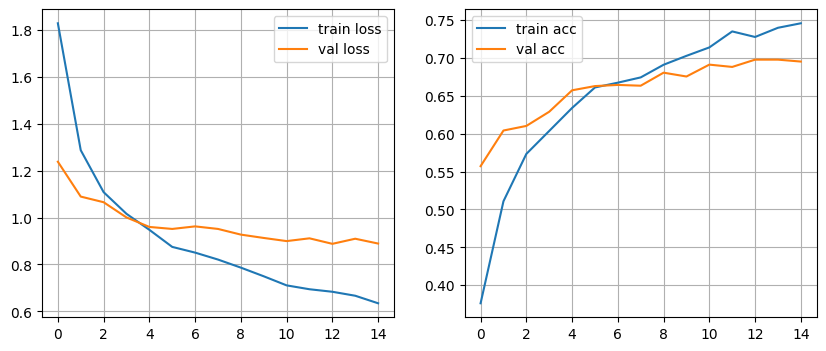

In [20]:
# plotting the changes after the fact

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_phase1.history["loss"], label="train loss")
plt.plot(history_phase1.history.get("val_loss", []), label="val loss")
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(history_phase1.history["accuracy"], label="train acc")
plt.plot(history_phase1.history.get("val_accuracy", []), label="val acc")
plt.legend(); plt.grid()

plt.show()


In [21]:
# ============================================================
# Fine-tuning - Phase 2
# ============================================================

import tensorflow as tf

# Number of layers to fine-tune from the end
FINE_TUNE_LAYERS = 100

# Freeze all layers first
for layer in model.layers:
    layer.trainable = False

# Unfreeze last N layers (except BatchNorm)
for layer in model.layers[-FINE_TUNE_LAYERS:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Recompile with lower learning rate (critical)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=20,
    verbose=1
)

Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 59s 172ms/step - accuracy: 0.3743 - loss: 1.5680 - val_accuracy: 0.5000 - val_loss: 1.2767
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - accuracy: 0.4882 - loss: 1.2755 - val_accuracy: 0.6007 - val_loss: 1.0069
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - accuracy: 0.5809 - loss: 1.0544 - val_accuracy: 0.6194 - val_loss: 0.9328
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.6413 - loss: 0.8955 - val_accuracy: 0.6974 - val_loss: 0.8184
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.7051 - loss: 0.7624 - val_accuracy: 0.7146 - val_loss: 0.7900
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.7224 - loss: 0.6915 - val_accuracy: 0.7530 - val_loss: 0.6967
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.7592 - loss: 0.6062 - val_accuracy: 0.7100 - val_loss: 0.7593
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.7866 - loss: 0.5

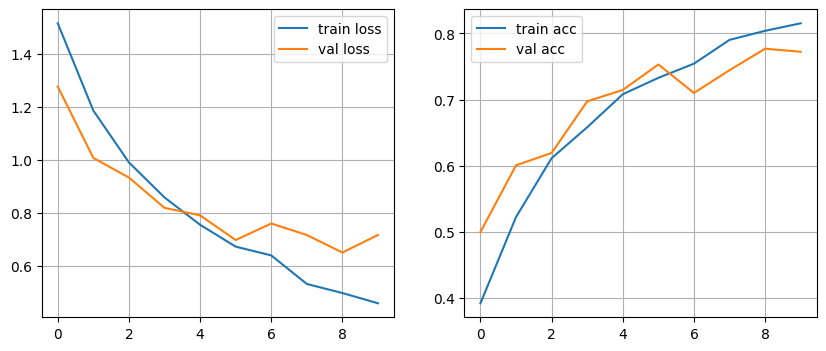

In [22]:
# plotting the changes after the fact

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_phase2.history["loss"], label="train loss")
plt.plot(history_phase2.history.get("val_loss", []), label="val loss")
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(history_phase2.history["accuracy"], label="train acc")
plt.plot(history_phase2.history.get("val_accuracy", []), label="val acc")
plt.legend(); plt.grid()

plt.show()


### **We now replace the dummy prediction function**

In [23]:
def predict_with_my_solid_model(test_files):
    """
    Predict labels for the test set using the trained CNN.
    """
    predictions = []

    for f in test_files:
        img = load_single_image(f)
        img = np.expand_dims(img, axis=0)  # (1, H, W, C)

        probs = model.predict(img, verbose=0)
        pred_idx = np.argmax(probs, axis=1)[0]
        predictions.append(index_to_label[pred_idx])

    return predictions

### **Generate submission**

In [24]:
y_test_pred = predict_with_my_solid_model(test_files)

test_ids_sr = pd.Series(test_ids, name="Id")
y_test_pred_sr = pd.Series(y_test_pred, name="Label")

submission_df = pd.concat([test_ids_sr, y_test_pred_sr], axis=1)
submission_df.head()

,Id,Label
0,10001,google
1,10002,mozilla
2,10003,samsung
3,10004,facebook
4,10005,samsung


In [25]:
submission_df.to_csv("submission.csv", index=False)